In [1]:
import json
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
%matplotlib inline

# Carga de los conjuntos de datos

In [2]:
t_start = time()
train_data = pd.read_csv('./datasets/en_data_train.csv', sep='\s*,\s*', header=0, encoding='ascii', engine='python')
test_data = pd.read_csv('./datasets/en_data_test.csv', sep='\s*,\s*', header=0, encoding='ascii', engine='python')
test_data_spanish = pd.read_csv('./datasets/es_data_test.csv', sep='\s*,\s*', header=0, encoding='ascii', engine='python')
test_data_arab = pd.read_csv('./datasets/ar_data_test.csv', sep='\s*,\s*', header=0, encoding='ascii', engine='python')
print("{} segundos cargando los conjuntos de datos".format(time() - t_start))

84.98687553405762 segundos cargando los conjuntos de datos


# Clasificación usando vectores promedio 

In [3]:
def create_avg_dataset(dataframe, json_labels_file_path):
    X = dataframe.groupby('author_id').mean()
    with open(json_labels_file_path) as json_file:
        dict_of_labels = json.loads(json_file.read())
    y = [dict_of_labels[author_id] for author_id, row in X.iterrows()]
    return X, y

In [4]:
X, y = create_avg_dataset(train_data, './authors_labels/en_train_labels.json')
X_test, y_test = create_avg_dataset(test_data, './authors_labels/en_test_labels.json')
X_test_spanish, y_test_spanish = create_avg_dataset(test_data_spanish, './authors_labels/es_test_labels.json')
X_test_arab, y_test_arab = create_avg_dataset(test_data_arab, './authors_labels/ar_test_labels.json')

## Entrenamiento de la SVM (promedios)

In [5]:
from sklearn.svm import SVC
t_start = time()
svclassifier = SVC(kernel='linear')
svclassifier.fit(X, y)
joblib.dump(svclassifier, 'svm_kernel_lin_avg.sav')
print("{} seconds training SVM".format(time() - t_start))

10.575647592544556 seconds training SVM


In [61]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
t_start = time()
# param = [{"C": [0.01, 0.1, 1, 10, 100, 1000]}]
svm = LinearSVC(C=1)
# clf = GridSearchCV(svm, param, cv=10)
svm.fit(X, y)
joblib.dump(svm, 'svm_kernel_lin_avg_grid.sav')
print("{} seconds training SVM".format(time() - t_start))

0.2757377624511719 seconds training SVM


## Prueba monolingüe (inglés - inglés)

In [62]:
import pickle
loaded_model_svclassifier = joblib.load('svm_kernel_lin_avg_grid.sav')

In [63]:
y_pred = loaded_model_svclassifier.predict(X_test)

In [64]:
print("Matriz de confusión")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Exactitud {}".format(accuracy_score(y_test, y_pred)))


Matriz de confusión
[[655 295]
 [277 673]]
              precision    recall  f1-score   support

      female       0.70      0.69      0.70       950
        male       0.70      0.71      0.70       950

   micro avg       0.70      0.70      0.70      1900
   macro avg       0.70      0.70      0.70      1900
weighted avg       0.70      0.70      0.70      1900

Exactitud 0.6989473684210527


## Prueba crosslingüe (inglés - español)

In [65]:
y_pred_spanish = loaded_model_svclassifier.predict(X_test_spanish)

In [66]:
print("Matriz de confusión")
print(confusion_matrix(y_test_spanish, y_pred_spanish))  
print(classification_report(y_test_spanish, y_pred_spanish))
print("Exactitud {}".format(accuracy_score(y_test_spanish, y_pred_spanish)))

Matriz de confusión
[[724 376]
 [357 743]]
              precision    recall  f1-score   support

      female       0.67      0.66      0.66      1100
        male       0.66      0.68      0.67      1100

   micro avg       0.67      0.67      0.67      2200
   macro avg       0.67      0.67      0.67      2200
weighted avg       0.67      0.67      0.67      2200

Exactitud 0.6668181818181819


## Prueba crosslingüe (inglés - árabe)

In [67]:
y_pred_arab = loaded_model_svclassifier.predict(X_test_arab)

In [68]:
print("Matriz de confusión")
print(confusion_matrix(y_test_arab, y_pred_arab))  
print(classification_report(y_test_arab, y_pred_arab))
print("Exactitud {}".format(accuracy_score(y_test_arab, y_pred_arab)))

Matriz de confusión
[[368 132]
 [178 322]]
              precision    recall  f1-score   support

      female       0.67      0.74      0.70       500
        male       0.71      0.64      0.68       500

   micro avg       0.69      0.69      0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000

Exactitud 0.69


In [39]:
top_n = 100
freq_instances = train_data.groupby('class').sum()
females_freqs = freq_instances.loc["female", :]
males_freqs = freq_instances.loc["male", :]
males_freqs = males_freqs.sort_values(ascending=False)
males_top_n_categories = males_freqs.keys()[:top_n]
females_freqs = females_freqs.sort_values(ascending=False)
females_top_n_categories = females_freqs.keys()[:top_n]


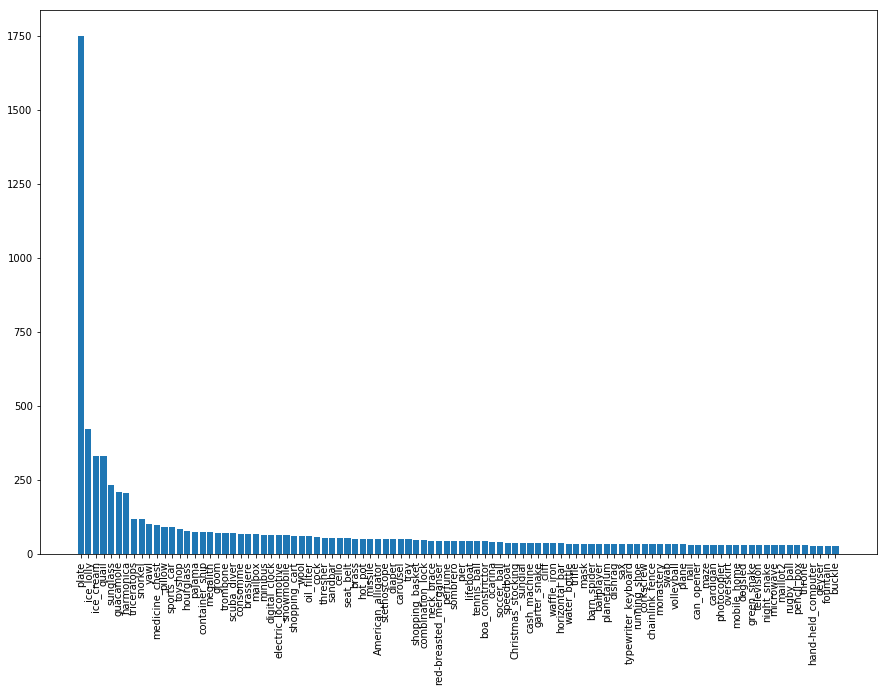

In [40]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.bar(males_top_n_categories, males_freqs[:top_n])
plt.xticks(np.arange(top_n), males_top_n_categories, rotation=90)
plt.show()

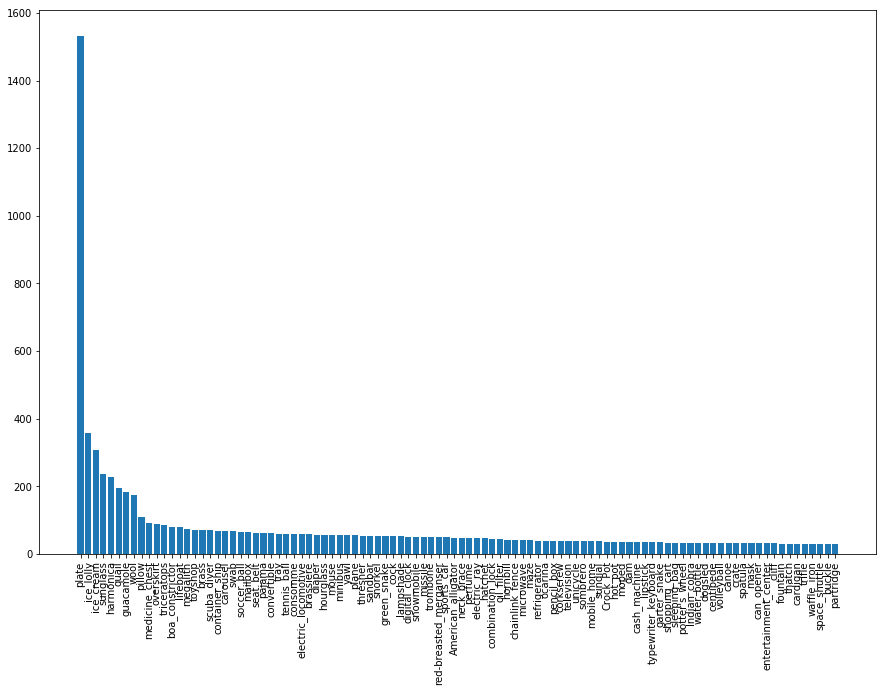

In [14]:
plt.bar(females_top_n_categories, females_freqs[:top_n])
plt.xticks(np.arange(top_n), females_top_n_categories, rotation=90)
plt.show()

In [15]:
print("Intersección {}".format(len(set(males_top_n_categories).intersection(set(females_top_n_categories)))))
males_categories = [c for c in males_top_n_categories if c not in females_top_n_categories]
female_categories = [c for c in females_top_n_categories if c not in males_top_n_categories]

Intersección 77


In [16]:
from IPython.display import HTML

table_male_str = """<table>
<tr>
<th>Categoría</th>
<th>Frecuencia</th>
</tr>"""

for c in males_categories:
    table_male_str += "<tr>"
    table_male_str += "<td>{}</td><td>{}</td>".format(c, males_freqs[c])
    table_male_str += "</tr>"
table_male_str += "</table>"
display(HTML(table_male_str))

Categoría,Frecuencia
groom,72.44342752419004
cello,53.141096213218056
stethoscope,50.39318299785728
shopping_basket,48.26079360242036
pier,44.10983258986513
speedboat,38.55581034895291
Christmas_stocking,38.04096568414543
horizontal_bar,36.239606535247596
barn_spider,35.025223144078694
ballplayer,34.280335763425455


In [17]:
table_female_str = """<table>
<tr>
<th>Categoría</th>
<th>Frecuencia</th>
</tr>"""

for c in female_categories:
    table_female_str += "<tr>"
    table_female_str += "<td>{}</td><td>{}</td>".format(c, females_freqs[c])
    table_female_str += "</tr>"
table_female_str += "</table>"
display(HTML(table_female_str))

Categoría,Frecuencia
convertible,60.98693039084846
mouse,55.92154345924264
lampshade,52.089260817203844
electric_ray,46.27042282842437
hatchet,46.25418774428395
hornbill,42.003447087126936
refrigerator,40.00167254918652
unicycle,38.40910172218851
Crock_Pot,37.03915609194892
moped,35.95814382436201


In [15]:
from sklearn.feature_selection import mutual_info_classif
res = dict(zip(X.keys(), mutual_info_classif(X, y)))

In [16]:
for key in sorted(res, key=res.get, reverse=True):
    print("{} : {}".format(key, res[key]))

overskirt : 0.060072915334231425
washbasin : 0.058576115897507774
lifeboat : 0.044190880534826116
mousetrap : 0.04324547387874822
wool : 0.04042454585227362
electric_ray : 0.04018165370264559
swab : 0.038106945072441833
convertible : 0.03780710946179866
snorkel : 0.03682839985668673
hatchet : 0.03568957071909762
African_crocodile : 0.03171536638112804
broom : 0.03123304218051981
coffeepot : 0.030689451286188163
spotted_salamander : 0.03045920918656364
paddlewheel : 0.030388040707963748
crane.1 : 0.030215772867112634
mouse : 0.02997273796710176
sleeping_bag : 0.026993023981484177
piggy_bank : 0.026555310693802348
spatula : 0.025880863150399502
green_mamba : 0.025845377041146644
moped : 0.02517361452203426
radio_telescope : 0.024952760297799692
lipstick : 0.02414133143860675
quill : 0.024022698867428582
tiger_cat : 0.023796178405033785
pier : 0.023783163818141162
boa_constrictor : 0.02369675745704436
Bernese_mountain_dog : 0.02356906877371845
plate_rack : 0.023525265329747524
Greater_Swi

## Clasificación usando votación

In [77]:
X_votes_train = train_data.drop("author_id", axis=1)
X_votes_train = X_votes_train.drop("class", axis=1)
y_votes_train = train_data['class']
t_start = time()
svclassifier_votes = LinearSVC()
svclassifier_votes.fit(X_votes_train, y_votes_train)
print("{} seconds training SVM".format(time() - t_start))

4.200283765792847 seconds training SVM


In [78]:
joblib.dump(svclassifier_votes, 'svm_kernel_lin_votes.sav')

['svm_kernel_lin_votes.sav']

In [79]:
def complete_pred_to_voted_pred(list_of_authors, y_pred):
    y_voted_pred = []
    current_author = list_of_authors[0]
    c_males = c_females = 0
    print(len(list_of_authors), len(y_pred))
    for i in range(1, len(list_of_authors)):
        if current_author == list_of_authors[i]:
            if y_pred[i] == 'male':
                c_males += 1
            else:
                c_females += 1
        else:
            current_author = list_of_authors[i]
            c_label = 'female' if c_females > c_males else 'male'
            y_voted_pred.append(c_label)
            c_males = c_females = 0
    c_label = 'female' if c_females > c_males else 'male'
    y_voted_pred.append(c_label)    
    return y_voted_pred

In [80]:
list_of_authors = [row for row in test_data['author_id']]
svm_votes = joblib.load('svm_kernel_lin_votes_c_10.sav')

In [81]:
X_votes_test = test_data.drop("author_id", axis=1)
X_votes_test = X_votes_test.drop("class", axis=1)
y_votes_test = test_data['class']
y_votes_pred = svm_votes.predict(X_votes_test)

In [82]:
with open('./authors_labels/en_test_labels.json') as json_file:
    dict_of_labels = json.loads(json_file.read())
y_votes_pred_aux = complete_pred_to_voted_pred(list_of_authors, y_votes_pred)
y_true = [dict_of_labels[author_id] for author_id, row in test_data.groupby('author_id').sum().iterrows()]

18997 18997


In [83]:
print("Matriz de confusión")
print(confusion_matrix(y_true, y_votes_pred_aux))
print(classification_report(y_true, y_votes_pred_aux))
print("Exactitud {}".format(accuracy_score(y_true, y_votes_pred_aux)))


Matriz de confusión
[[452 498]
 [444 506]]
              precision    recall  f1-score   support

      female       0.50      0.48      0.49       950
        male       0.50      0.53      0.52       950

   micro avg       0.50      0.50      0.50      1900
   macro avg       0.50      0.50      0.50      1900
weighted avg       0.50      0.50      0.50      1900

Exactitud 0.5042105263157894
